# Import Libraries

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
tf.__version__

'2.6.2'

# Load VGG19

In [2]:
# we load VGG19 here just to find out the name of the layers
# we won't be using the network object initialized below
network = tf.keras.applications.VGG19(include_top=False, #only convolution and maxpooling layers to include
                                     weights='imagenet' #include weights
                                    )
network.summary()

2022-01-13 07:40:27.838461: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-13 07:40:27.942003: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-13 07:40:27.942689: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-13 07:40:27.943736: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

80150528/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

In [3]:
len(network.layers)

22

# Load And Preprocess Images

## Content Image

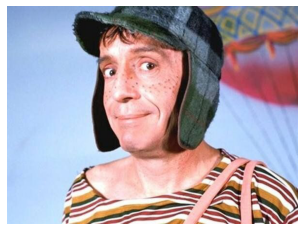

In [4]:
content_image = tf.keras.preprocessing.image.load_img('../input/deepdream/chaves.jpeg')
plt.axis('off')
plt.imshow(content_image);

In [5]:
type(content_image)

PIL.JpegImagePlugin.JpegImageFile

In [6]:
content_image = tf.keras.preprocessing.image.img_to_array(content_image)
type(content_image), content_image.shape

(numpy.ndarray, (448, 598, 3))

In [7]:
#normalize the image
content_image = content_image / 255

In [8]:
# convert int obatch format
content_image = content_image[tf.newaxis, :]
content_image.shape

(1, 448, 598, 3)

## Style Image

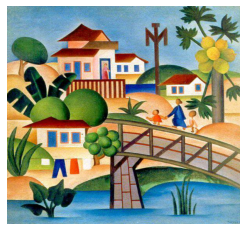

In [9]:
style_image = tf.keras.preprocessing.image.load_img('../input/deepdream/tarsila_amaral.jpg')
plt.axis('off')
plt.imshow(style_image);

In [10]:
style_image = tf.keras.preprocessing.image.img_to_array(style_image)

#normalize the image
style_image = style_image / 255

# convert int obatch format
style_image = style_image[tf.newaxis, :]

type(style_image), style_image.shape

(numpy.ndarray, (1, 560, 600, 3))

# Building Model

From the VGG19 network, it is found that the below layers outputs contents and style information
Therefore, the style layers' outputs from one image are extracted and applied to content layers of another image to transfer style

In [11]:
content_layers = ['block4_conv2'] #1 content layer
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1'] #5 style layers

In [12]:
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)
num_content_layers, num_style_layers

(1, 5)

In [13]:
network.input

<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_1')>

In [14]:
#function to return activation values from a layer
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, #load the model to use the layer_names activation output
                                    weights='imagenet')
    vgg.trainable = False # not going to train the network. Only weights is to be used
    
    outputs =[vgg.get_layer(name).output for name in layer_names] #get activations from the specified layers
    
    network = tf.keras.Model(inputs = [vgg.input], outputs=outputs)
    return network

In [15]:
# test the above function
style_extractor = vgg_layers(style_layers)
style_extractor.summary()
# seems the network is same as VGG19 (not like that, here there are 5 output layers while in VGG19  there is only one output layer)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [16]:
network.outputs #only one output for VGG19

[<KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block5_pool')>]

In [17]:
style_outputs = style_extractor(style_image) #see below that there are 5 output layers
style_outputs

2022-01-13 07:40:33.915493: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


[<tf.Tensor: shape=(1, 560, 600, 64), dtype=float32, numpy=
 array([[[[0.0000000e+00, 1.1168056e-01, 6.2121809e-02, ...,
           4.7374946e-01, 4.9520522e-01, 1.5619564e-01],
          [0.0000000e+00, 2.1199909e-01, 3.7911364e-01, ...,
           1.7614037e-01, 1.4901578e+00, 1.1453360e+00],
          [0.0000000e+00, 2.0160642e-01, 3.8564062e-01, ...,
           1.3608325e-01, 1.5308917e+00, 1.1796422e+00],
          ...,
          [0.0000000e+00, 3.3286181e-01, 5.1675826e-01, ...,
           0.0000000e+00, 1.6993666e+00, 1.3342988e+00],
          [0.0000000e+00, 3.4320116e-01, 5.2286661e-01, ...,
           0.0000000e+00, 1.7050551e+00, 1.3393183e+00],
          [7.8187567e-01, 4.2259818e-01, 7.7565944e-01, ...,
           4.4906515e-01, 2.4665630e+00, 2.3771269e+00]],
 
         [[0.0000000e+00, 1.1404040e-01, 0.0000000e+00, ...,
           7.9952955e-02, 0.0000000e+00, 0.0000000e+00],
          [6.3841367e-01, 2.4004281e-01, 3.5869697e-01, ...,
           0.0000000e+00, 5.8317912

In [18]:
len(style_outputs) #gives activation outputs of the 5 layers given the style image as input

5

In [19]:
style_outputs[0].shape, style_outputs[1].shape, style_outputs[2].shape, style_outputs[3].shape, style_outputs[4].shape, 

(TensorShape([1, 560, 600, 64]),
 TensorShape([1, 280, 300, 128]),
 TensorShape([1, 140, 150, 256]),
 TensorShape([1, 70, 75, 512]),
 TensorShape([1, 35, 37, 512]))

In [20]:
def gram_matrix(layer_activation): #activation value of a layer
    result = tf.linalg.einsum('bijc,bijd->bcd', layer_activation, layer_activation) #code extracted from documentation of style transfer
    input_shape = tf.shape(layer_activation)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32) # for normalization
    
    return result / num_locations #normalized value

In [21]:
gram_matrix(style_outputs[0])

<tf.Tensor: shape=(1, 64, 64), dtype=float32, numpy=
array([[[0.631103  , 0.28949898, 0.28517228, ..., 0.1051826 ,
         0.36955735, 0.45017177],
        [0.28949898, 0.24226907, 0.18415499, ..., 0.03151667,
         0.19604628, 0.2170014 ],
        [0.28517228, 0.18415499, 0.16761073, ..., 0.02775798,
         0.19407691, 0.22697577],
        ...,
        [0.1051826 , 0.03151667, 0.02775798, ..., 0.08261998,
         0.06934635, 0.06634998],
        [0.36955735, 0.19604628, 0.19407691, ..., 0.06934635,
         0.28692862, 0.3186243 ],
        [0.45017177, 0.2170014 , 0.22697577, ..., 0.06634998,
         0.3186243 , 0.37485763]]], dtype=float32)>

In [22]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super().__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False
    #call can be invoked as obj()
    def call(self, inputs): #inputs - content image
        inputs = inputs * 255.0 #undo normalization since preprocessing is done with rspect to VGG19 (which is done below)
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input) #contains activation outputs of style and content layers
        style_outputs = outputs[:self.num_style_layers] #activation outputs of style layers
        content_outputs = outputs[self.num_style_layers:] #activation outputs of content layers
        
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
        
        content_dict = {content_name: value for content_name, value in zip(self.content_layers, content_outputs)}
        style_dict = {style_name: value for style_name, value in zip(self.style_layers, style_outputs)}
        
        return {'content':content_dict, 'style':style_dict}

In [23]:
style_layers, content_layers

(['block1_conv1',
  'block2_conv1',
  'block3_conv1',
  'block4_conv1',
  'block5_conv1'],
 ['block4_conv2'])

In [24]:
extractor = StyleContentModel(style_layers, content_layers)
results = extractor(content_image)
results

{'content': {'block4_conv2': <tf.Tensor: shape=(1, 56, 74, 512), dtype=float32, numpy=
  array([[[[  17.105864,    0.      ,    0.      , ...,  574.59784 ,
               0.      ,    0.      ],
           [   0.      ,    0.      ,    0.      , ...,  291.4189  ,
             132.35054 ,    0.      ],
           [   0.      ,    0.      ,    0.      , ...,  332.05222 ,
             118.952255,    0.      ],
           ...,
           [ 700.125   ,    0.      ,    0.      , ..., 1511.4629  ,
              11.206586,  325.48337 ],
           [ 141.86795 ,    0.      ,    0.      , ..., 1099.7534  ,
              96.57431 ,  195.72565 ],
           [ 137.43658 ,    0.      ,    0.      , ...,  469.20245 ,
             180.22145 ,  676.20026 ]],
  
          [[   0.      ,    0.      ,    0.      , ...,  549.1027  ,
               0.      ,    0.      ],
           [   0.      ,    0.      ,    0.      , ...,   44.160744,
               0.      ,    0.      ],
           [   0.      ,    0

In [25]:
for key, value in results.items():
    print(key,'-', value.keys())

content - dict_keys(['block4_conv2'])
style - dict_keys(['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1'])


In [26]:
style_targets = extractor(style_image)['style'] #5 activation layers' outputs
contents_targets = extractor(content_image)['content'] #1 activation layer's output
len(style_targets), len(contents_targets)

# generated image is compared with original content image to minimize the content loss
# also, generated image is compared with original style image to minimize the style loss

(5, 1)

In [27]:
transferred_image = tf.Variable(content_image) #copy of content image which is to be style transfered from style image during training

content_weights = 1 #units of contents needed in the final result
style_weights = 1000 #units of styles needed in the final result

In [28]:
optimizer = tf.optimizers.Adam(learning_rate = 0.02)

# Training

Epoch : 500 | Content Loss : 622485.75 | Style Loss : 203004160.0 | Total Loss : 40601456640.0


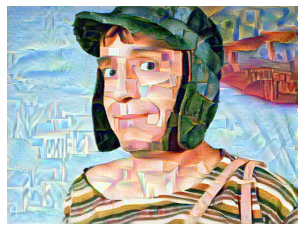

Epoch : 1000 | Content Loss : 655626.4375 | Style Loss : 188525104.0 | Total Loss : 37705674752.0


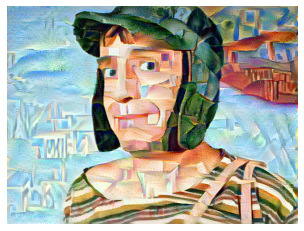

Epoch : 1500 | Content Loss : 670232.625 | Style Loss : 240723536.0 | Total Loss : 48145379328.0


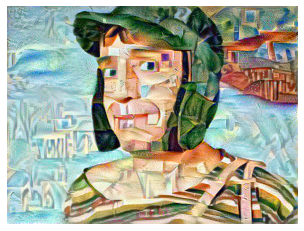

Epoch : 2000 | Content Loss : 693107.75 | Style Loss : 75053224.0 | Total Loss : 15011339264.0


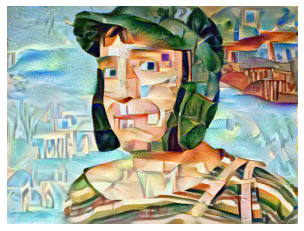

Epoch : 2500 | Content Loss : 698662.0625 | Style Loss : 98875416.0 | Total Loss : 19775780864.0


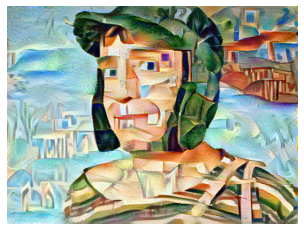

Epoch : 3000 | Content Loss : 707357.5 | Style Loss : 86118064.0 | Total Loss : 17224318976.0


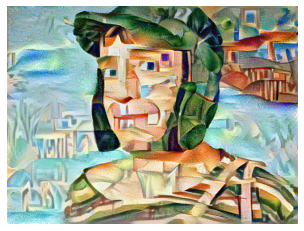

Epoch : 3500 | Content Loss : 710776.125 | Style Loss : 115070760.0 | Total Loss : 23014862848.0


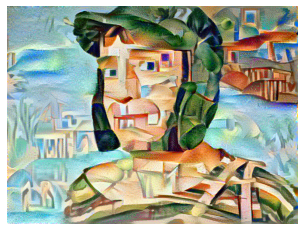

Epoch : 4000 | Content Loss : 721756.875 | Style Loss : 64132096.0 | Total Loss : 12827141120.0


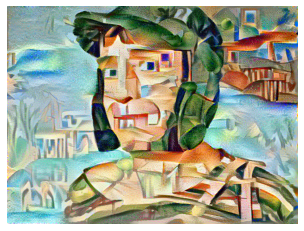

Epoch : 4500 | Content Loss : 727237.8125 | Style Loss : 47266412.0 | Total Loss : 9454009344.0


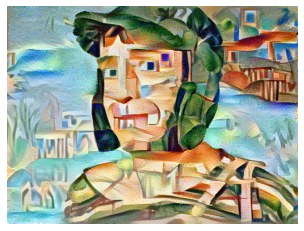

Epoch : 5000 | Content Loss : 731242.75 | Style Loss : 56769136.0 | Total Loss : 11354558464.0


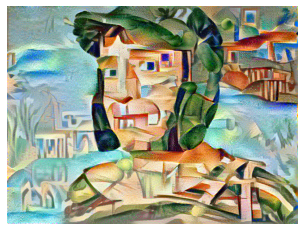

In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

epochs = 5000
display_epoch = 500

for epoch in range(epochs):
    with tf.GradientTape() as tape:
    #get gradients since we need to update the pixels of images and not the weights using gradients as like traditional NN
        outputs = extractor(transferred_image)
        content_outputs = outputs['content']
        style_outputs = outputs['style']
        
        # loss is calculated since transfer is to be done only to certain
        # amount since more the transfer may cause the image to transfer totally
        content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - contents_targets[name])**2) for name in content_outputs.keys()])
        style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name])**2) for name in style_outputs.keys()])
        #single metric to combine both loss
        total_loss = (content_loss * content_weights / num_content_layers) + (style_loss * style_weights / num_style_layers)
    
    #calculate gradient of loss with respect to image
    gradient = tape.gradient(total_loss, transferred_image)
    
    optimizer.apply_gradients([(gradient, transferred_image)]) #apply the optimizer on the image to tune the model
    
    transferred_image.assign(tf.clip_by_value(transferred_image, 0.0, 1.0)) # clip the values in the range [0, 1] 
    
    if((epoch +1) % display_epoch == 0): #display interval
        print('Epoch : {} | Content Loss : {} | Style Loss : {} | Total Loss : {}'.format(epoch+1, content_loss, style_loss, total_loss))
        plt.axis('off')
        plt.imshow(tf.squeeze(transferred_image, axis = 0)); # shape = (1, 448, 598, 3) => (448, 589, 3)
        plt.show()

# Visualizing the Results

Text(0.5, 1.0, 'Transferred Image')

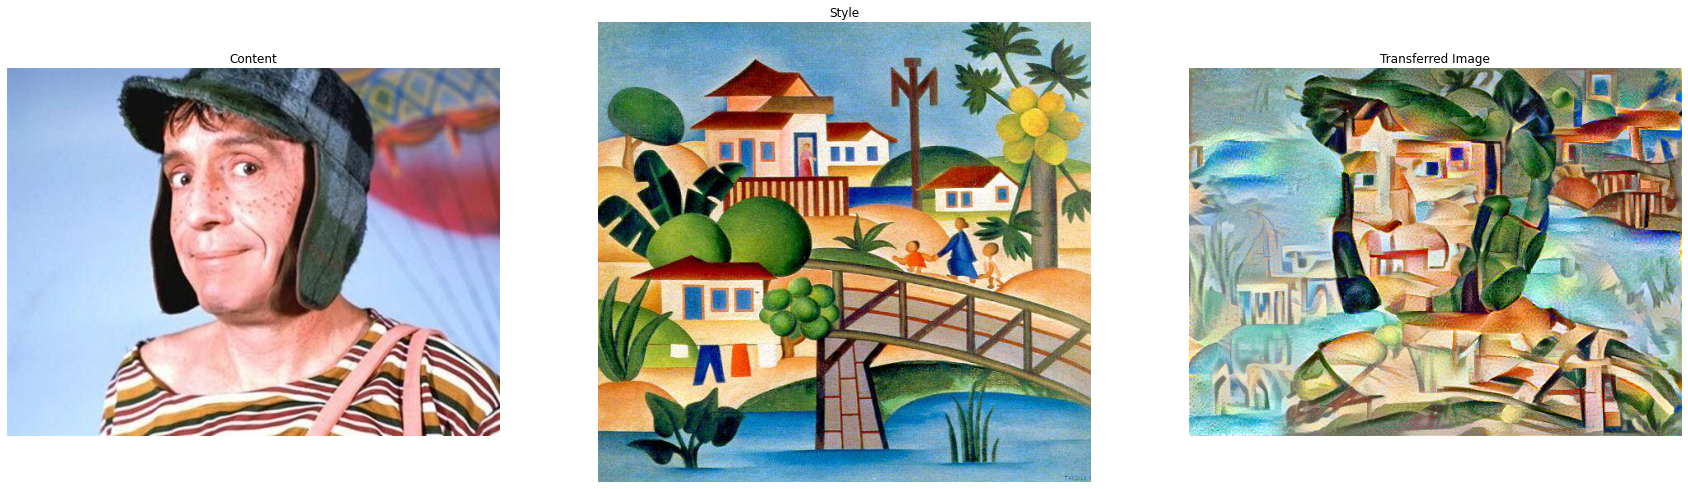

In [30]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))
ax1.axis('off')
ax1.imshow(tf.squeeze(content_image, axis=0))
ax1.set_title('Content')

ax2.axis('off')
ax2.imshow(tf.squeeze(style_image, axis=0))
ax2.set_title('Style')

ax3.axis('off')
ax3.imshow(tf.squeeze(transferred_image, axis=0))
ax3.set_title('Transferred Image')